In [5]:
import os.path
from os import path
import requests
import shutil
import cv2

from sklearn.cluster import MiniBatchKMeans

PATH_TO_RESOURCES = "../resources"

In [6]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [18]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [19]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

In [20]:
import re
import numpy as np

In [21]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [22]:
class SymbolExtractor():
    def __init__(self):
        self.masks = []
        
    def fit(self, X, y=None, sample_weight=None):
        for symbol in X:
            self.masks.append(np.sum(symbol, axis=2) < 255 * 3)
        
        return self
    
    def transform(self, X, copy=None):
        return [X[i][self.masks[i]] for i in range(len(X))]

In [23]:
class ColorReducer():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8, random_state=1)
        self.masks = None
        self.lut = None
        
    def fit(self, X, y=None, sample_weight=None):
        self.masks = [np.sum(X[0], axis=1) < 255 * 3]
        sample_pixels = X[0][self.masks[0]]
        for i in range(1, len(X)):
            self.masks.append(np.sum(X[i], axis=1) < 255 * 3)
            sample_pixels = np.concatenate((sample_pixels, X[i][self.masks[i]]), axis=0)
        # Train kmeans
        self.kmeans.fit(sample_pixels)

        # Create the LUT
        self.lut = np.uint8(self.kmeans.cluster_centers_)
        
        return self
    
    def transform(self, X, copy=None):
        recoloreds = []
        for i in range(len(X)):
            recolored = np.ones_like(X[i]) * 255
            recolored[self.masks[i]] = self.lut[np.uint8(self.kmeans.predict(X[i]))]
            recoloreds.append(recolored)
            
        return recoloreds

In [24]:
class ColorHistogram():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8)
        
    def fit(self, X, y=None, sample_weight=None):
        sample_pixels = X[0]
        for i in range(1, len(X)):
            sample_pixels = np.concatenate((sample_pixels, X[i]), axis=0)
            
        self.kmeans.fit(sample_pixels)
        
        return self
    
    def transform(self, X, copy=None):
        histograms = []
        for i in range(len(X)):
            histo = np.bincount(np.uint8(self.kmeans.predict(X[i])),
                        minlength = self.kmeans.n_clusters) / len(X[i])
            histograms.append(histo)

        return histograms

In [25]:
pipeline_transformers = [("extraction", SymbolExtractor()), ("color reduction", ColorReducer())]

In [26]:
extractor = ("color histogram", ColorHistogram())

## Useful fonctions

In [27]:
from sklearn.pipeline import Pipeline
import time
import matplotlib.pyplot as plt

In [36]:
def test_pipeline(classifier):
    steps = pipeline_transformers + [extractor, classifier]
    pipeline = Pipeline(steps, verbose=True)

    fit_time = 0
    score = 0
    score_time = 0
    for _ in range(5):
        start = time.process_time()
        pipeline.fit(symbols, symbols_labels)
        fit_time += time.process_time() - start

        start = time.process_time()
        # TODO replace symbols with test set to score
        score += pipeline.score(symbols, symbols_labels)
        score_time += time.process_time() - start
    
    return "{:.3f} %".format(score / 5 * 100), "{:.3f} s".format(fit_time / 5), "{:.3f} s".format(score_time / 5)))

In [38]:
def print_benchmark(benchmark, arg_name):
    fig, ax =plt.subplots()
    column_labels=[arg_name, "Score", "CPU fit time", "CPU score time"]
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=benchmark,
                     colLabels=column_labels,
                     loc="center",
                     cellLoc="center")

    table.set_fontsize(20)
    table.scale(2, 2)

    plt.show()

## LinearSVC

In [39]:
from sklearn.svm import LinearSVC

On teste l'argument loss, c'est-à-dire la fonction de perte, qui peut être 'hinge', la fonction de perte standard, ou 'squared_hinge', qui est son carré.

[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 6.0min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=  20.5s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.1s


/home/nikow/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 5.9min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=  20.8s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.1s


/home/nikow/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 5.9min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=  20.9s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.1s


/home/nikow/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 4.6min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   7.1s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.1s


/home/nikow/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 1.1min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   8.0s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.1s


/home/nikow/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total= 1.1min
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   1.9s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  12.6s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   1.8s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  14.1s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   2.0s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  22.8s
[Pipel

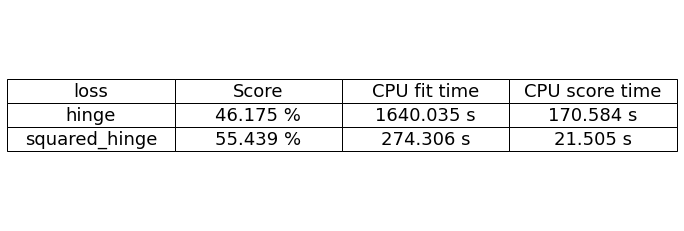

In [41]:
benchmark = []

classifier = ("LinearSVC clf", LinearSVC(loss='hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("hinge", score, fit_time, score_time)

classifier = ("LinearSVC clf", LinearSVC(loss='squared_hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("squared_hinge", score, fit_time, score_time)

print_benchmark(benchmark, "loss")

On teste maintenant la tolérance d'arrêt, tol.

In [ ]:
x_axis = []
scores = []
# TODO afficher courbes pour temps ?

for i in range(1, 11):
    classifier = ("LinearSVC clf", LinearSVC(tol=float(i)/10000.))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction de la valeur de tol")
plt.title("Résultats du classifier en fonction du paramètre tol")
plt.xlabel("tol")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  10.1s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   1.6s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  11.8s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   2.0s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  12.6s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   1.8s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  12.6s
[Pipel

[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  13.9s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   2.1s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  13.1s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   2.0s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  13.3s
[Pipeline] ... (step 3 of 4) Processing color histogram, total=   1.9s
[Pipeline] ..... (step 4 of 4) Processing LinearSVC clf, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing extraction, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing color reduction, total=  14.4s
[Pipel

Enfin, on teste le paramètre de régularisation, C.

In [ ]:
x_axis = []
scores = []
# TODO affich courbes pour temps ?

for i in range(5, 105, 5):
    classifier = ("LinearSVC clf", LinearSVC(C=float(i)/10.))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction de la valeur de C")
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

# TODO blabla sur ce qu'on peut ressortir

## KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

On teste d'abord le paramètre déterminant le nombre de voisins.

In [ ]:
x_axis = []
scores = []
# TODO afficher courbes pour temps ?

for i in range(1, 21):
    classifier = ("KNeighbours clf", KNeighborsClassifier(n_neighbors = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction du nombre de voisins")
plt.title("Résultats du classifier en fonction du nombre de voisins")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

Ensuite, teste en fonction des poids : soit "uniform", où tous les points ont le même poids, soit "distance", où leur poids est l'inverse de leur distance, donc les voisins proches ont plus d'influence.

In [ ]:
benchmark = []

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'uniform'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("uniform", score, fit_time, score_time)

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'distance'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("distance", score, fit_time, score_time)

print_benchmark(benchmark, "weights")

Enfin, testons en fonction de la taille des feuilles, leaf_size.

In [ ]:
x_axis = []
scores = []
# TODO afficher courbes pour temps ?

for i in range(5, 65, 5):
    classifier = ("KNeighbours clf", KNeighborsClassifier(leaf_size = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction de la taille des feuilles")
plt.title("Résultats du classifier en fonction de la taille des feuilles")
plt.xlabel("leaf_size")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

## KNeighbors

In [43]:
from sklearn.svm import SVC

On teste tout d'abord le paramètre de régularisation, C.

In [ ]:
x_axis = []
scores = []
# TODO affich courbes pour temps ?

for i in range(5, 105, 5):
    classifier = ("SVC clf", SVC(C=float(i)/10.))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction de la valeur de C")
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

On teste maintenant le paramètre kernel.

In [ ]:
benchmark = []

classifier = ("SVC clf", SVC(kernel = 'linear'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("linear", score, fit_time, score_time)

classifier = ("SVC clf", SVC(kernel = 'poly'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("poly", score, fit_time, score_time)

classifier = ("SVC clf", SVC(kernel = 'rbf'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("rbf", score, fit_time, score_time)

classifier = ("SVC clf", SVC(kernel = 'sigmoid'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("sigmoid", score, fit_time, score_time)

classifier = ("SVC clf", SVC(kernel = 'precomputed'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append("precomputed", score, fit_time, score_time)

print_benchmark(benchmark, "kernel")

Enfin, testons le paramètre degree (correspondant au degré de la fonction polynomiale du kernel (si on met 'poly' en paramètre kernel).

In [ ]:
x_axis = []
scores = []
# TODO affich courbes pour temps ?

for i in range(1, 16):
    classifier = ("SVC clf", SVC(kernel = 'poly', degree = i)
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
plt.plot(x_axis, scores, label="Score en fonction du degré")
plt.title("Résultats du classifier en fonction du degré")
plt.xlabel("degree")
plt.ylabel("Score")
plt.legend()

ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()

plt.ylim(-5,105)
plt.show()

# TODO BLABLABLA